# Introduction au réservoir optique de Larger

Après avoir découvert l'idée du reservoir computing avec sa forme la plus classique, l'*echo state network*, où le réservoir prend la forme d'un réseau de neurones récurrent, on s'intéresse ici à une autre forme de réservoir, implémentable sur un support opto-électronique.

L'objectif de ce TP est de prendre en main ce système, et son implémentation ReservoirPy, disponible ici: https://github.com/reservoirpy/presentations/blob/main/Institut-d-optique-2024-2025/model.py

**Article original:**
Larger, L., ... & Fischer, I. (2012). *Photonic information processing beyond Turing: an optoelectronic implementation of reservoir computing.* Optics express, 20(3), 3241-3249.
Accès au fichier PDF de l'article : https://opg.optica.org/viewmedia.cfm?uri=oe-20-3-3241&seq=0

In [4]:
# Passez à la version la plus à jour de reservoirpy 0.3.*
# Allez voir sur le GitHub de reservoirpy pour voir la dernière version publiée 
# et changez complétez le nombre à la place de "*"
%pip install reservoirpy==0.3.*
#%pip install reservoirpy==0.3.15 # <- dernière version au jour du TP

In [2]:
# IMPORTS

import joblib
import numpy as np
from reservoirpy.datasets import mackey_glass
import matplotlib.pyplot as plt
from matplotlib import colors

import reservoirpy as rpy
rpy.verbosity(0)

from model import Larger


In [3]:
# HYPER-PARAMÈTRES

# Nombre de points temporels
n_neurones = 50

# Retard de la boucle
tau = 125e-6
# Temps de réponse du détecteur
epsilon = tau / (0.2 * n_neurones)
# Gain non-linéaire
beta = 1.5
# Bias  
phi = 0.5
# paramètre équivalent au coef de réflexion du coupleur d'une cavité en anneau
rho = 0.8
# paramètre équivalent au coef de transmission du coupleur d'une cavité en anneau
kappa = 0.5

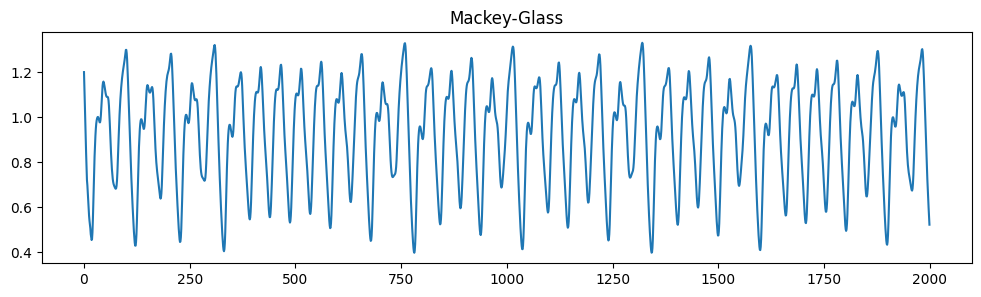

In [4]:
# DÉFINITION DE LA SÉRIE TEMPORELLE (signal)

n_tours = 2000  # Nombre de tours de boucle

timeseries = mackey_glass(n_timesteps=n_tours)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
plt.plot(timeseries)
plt.title("Mackey-Glass")
plt.show()

In [5]:
# CRÉATION DU RÉSERVOIR

# Remplissez tous les paramètres en allant voir dans le fichier model.py où se trouve le noeud reservoir Larger
reservoir = Larger(# ... A COMPLETER ... 

In [6]:
# LANCER LE RÉSERVOIR SUR LA SÉRIE

output = reservoir.# ... A COMPLETER ...
print(f"{output.shape=}")

output.shape=(2000, 50)


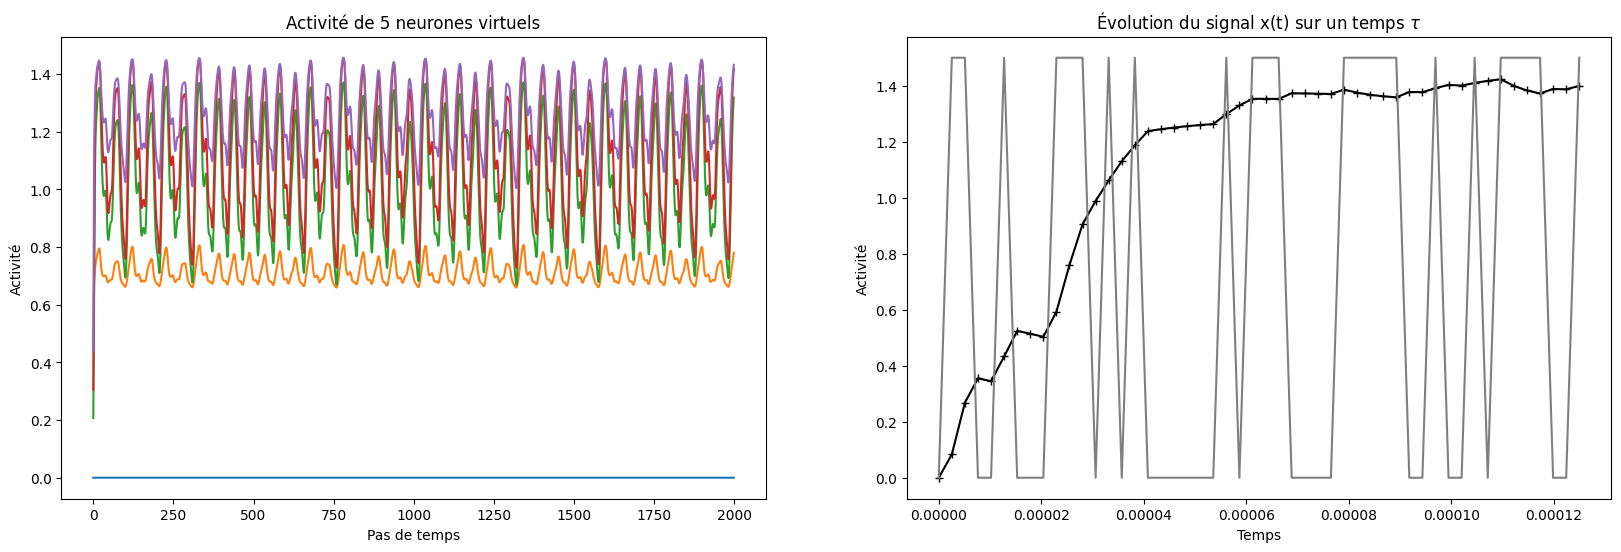

In [7]:
# AFFICHAGE DE L'ACTIVITÉ
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

ax[0].plot(output[:, ::10])
ax[0].set_title("Activité de 5 neurones virtuels")
ax[0].set_xlabel("Pas de temps")
ax[0].set_ylabel("Activité")

# Affichage de x(t) au 10ème pas de temps
ax[1].plot(np.linspace(0, tau, n_neurones), output[10, :], '-+', color="black", label="activity")
ax[1].plot(np.linspace(0, tau, n_neurones), reservoir.beta*(reservoir.input_mask[0]+1)/2, color="gray", label="input mask")
ax[1].set_title("Évolution du signal x(t) sur un temps $\\tau$")
ax[1].set_xlabel("Temps")
ax[1].set_ylabel("Activité")

plt.show()

### Évaluation sur une tâche de prédiction

Maintenant qu'on a observé l'activité, il est temps d'entraîner un modèle complet !
La syntaxe est la même que pour un echo state network classique.

In [8]:
# DÉFINITION DE LA TÂCHE DE PRÉDICTION

from reservoirpy.datasets import to_forecasting

X = mackey_glass(n_timesteps=n_tours)
# Ramener tout entre 0.0 et 1.0:
X = (X - X.min()) / (X.max() - X.min())

# Prédiction à 10 pas de temps, 20% des données servent à l'évaluation
dataset = to_forecasting(# ... A COMPLETER ...
x_train, x_test, y_train, y_test = dataset

In [9]:
# CRÉATION DU MODÈLE

# Il suffit de connecter le réservoir au read-out (couche de sortie)
from reservoirpy.nodes import Ridge

reservoir = Larger(# ... A COMPLETER ...
# On peut mettre ridge = 1e-8
readout = # ... A COMPLETER ...

model = # ... A COMPLETER ...

In [10]:
# ENTRAÎNEMENT DU MODÈLE AVEC UN WARMUP

# On peut mettre un warmup à 100
model.# ... A COMPLETER ...

'Model-0': Model('Larger-1', 'Ridge-0')

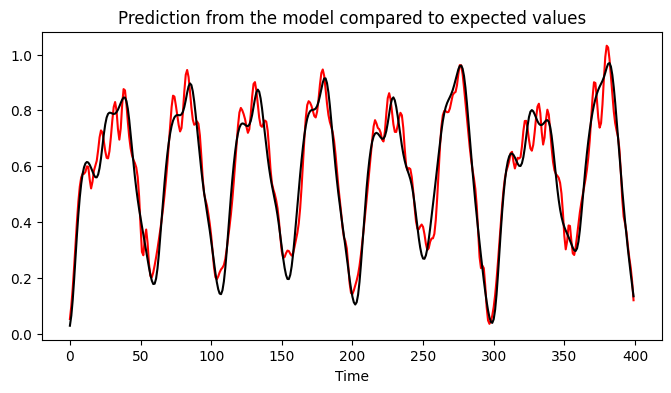

NRMSE = 0.057738944988930126


In [11]:
# ÉVALUATION DES RÉSULTATS

from reservoirpy.observables import nrmse

y_pred = model.run(x_test)

plt.figure(figsize=(8, 4))
plt.plot(y_pred, label="Prediction", color="red")
plt.plot(y_test, label="True", color="black")
plt.title("Prediction from the model compared to expected values")
plt.xlabel("Time")
plt.show()

print(f"NRMSE = {nrmse(y_pred=y_pred, y_true=y_test)}")

## Exploration des hyperparamètres avec la recherche aléatoire (random search)
Reprenez le tutoriel précédent avec vos recherches d'hyperparamètres
et adaptez avec les hyperparamètres du reservoir optique version Larger.

In [ ]:
# ... A COMPLETER ...

In [ ]:
# ... A COMPLETER ...

In [ ]:
# ... A COMPLETER ...

In [ ]:
# ... A COMPLETER ...

In [ ]:
# ... A COMPLETER ...

In [ ]:
# ... A COMPLETER ...

## Analyse mathématique de l'impact des hyper-paramètres

En se basant sur les deux premières visualisations, et sur les métriques d'erreur de prédiction, explorons l'impact des différents hyper-paramètres (`n_neurones`, $\epsilon, \beta, \kappa, \rho, \tau, \phi_0$) sur le réservoir optique.

En modifiant les hyper-paramètres listés plus haut, visualisez à la fois l'activité des neurones virtuels au cours du temps, et l'état des différents neurones au cours d'un temps $t \rightarrow t+\tau$

**Rappel de la formule:**
$$\epsilon {dx(t) \over dt} + x(t) = \beta sin^2(\kappa u_{in}(t) + \rho x(t - \tau) + \phi_0)$$

### Faisons varier les paramètres un-à-un

On n'explorera pas ici `n_neurones` (on s'attend à ce que plus de neurones apporte plus de richesse d'activité).

$\tau$ n'est pas non plus un paramètre à explorer: il y a une corrélation directe entre $\tau$ et $\epsilon$: concrètement, modifier $\tau$ revient à modifier la taille de la segmentation de l'activité du système $x(t)$, donc à faire tourner le réservoir plus rapidement. On peut alors obtenir la même dynamique en ajustant le temps de réponse du détecteur $\epsilon$.

In [12]:
n_neurones = 50  # Nombre de points temporels
tau = 125e-6  # Retard de la boucle
epsilon = tau / (0.2 * n_neurones)  # Temps de réponse du détecteur
beta = 1.5  # Gain non-linéaire
phi = 0.5  # Bias
rho = 0.8  # coef. de réflexion du coupleur d'une cavité en anneau
kappa = 0.5  # coef. de transmission du coupleur d'une cavité en anneau
ridge = 1e-6 # régularisation de la couche de sortie

# on réduit le nombre de pas de temps: temps d'entraînement/prédiction plus court
X = mackey_glass(n_timesteps=500)
X = (X - X.min()) / (X.max() - X.min())
dataset = to_forecasting(X, forecast=10, test_size=0.2)
x_train, x_test, y_train, y_test = dataset

In [13]:
def run_on_params(n_neurones, tau, epsilon, beta, phi, rho, kappa, ridge):
    reservoir = Larger(N=n_neurones, tau=tau, kappa=kappa, rho=rho, phi=phi, beta=beta, epsilon=epsilon)
    readout = Ridge(ridge=ridge)
    model = reservoir >> readout

    model.fit(x_train, y_train, warmup=10)
    y_pred = model.run(x_test)
    return y_pred

In [ ]:
$$\epsilon {dx(t) \over dt} + x(t) = \beta sin^2(\kappa u_{in}(t) + \rho x(t - \tau) + \phi_0) \\

{x(t+\delta t) - x(t) \over \delta t} = {1 \over \epsilon} [\beta sin^2(\kappa u_{in}(t) + \rho x(t - \tau) + \phi_0) - x(t)] \\

x(t+\delta t) = x(t) + {\delta t \over \epsilon} [\beta sin^2(\kappa u_{in}(t) + \rho x(t - \tau) + \phi_0) - x(t)] \\

x(t+\delta t) = (1 - {\delta t \over \epsilon}) x(t) + {\delta t \over \epsilon} [\beta sin^2(\kappa u_{in}(t) + \rho x(t - \tau) + \phi_0)]$$

#### Paramètre epsilon $\epsilon$

$\epsilon$ représente le taux de charge/décharge du système: une valeur élevée signifie que le signal $x(t)$ évolue plus lentement. Ainsi, entre un temps $t$ et $t + \delta t$, c'est à dire entre deux neurones virtuels voisins, le signal $x$ variera peu. On devrait alors observer une forte interdépendance entre les neurones.

On peut approximer la différence entre deux neurones virtuels en appliquant la méthode d'Euler sur l'équation différentielle plus haut:

$$
\begin{aligned}
\epsilon \frac{dx(t)}{dt} + x(t)
&= \beta \sin^2\!\bigl(\kappa u_{in}(t) + \rho x(t-\tau) + \phi_0\bigr) \\
\frac{x(t+\delta t)-x(t)}{\delta t}
&= \frac{1}{\epsilon}
\Bigl[\beta \sin^2\!\bigl(\kappa u_{in}(t) + \rho x(t-\tau) + \phi_0\bigr) - x(t)\Bigr] \\
x(t+\delta t)
&= x(t) + \frac{\delta t}{\epsilon}
\Bigl[\beta \sin^2\!\bigl(\kappa u_{in}(t) + \rho x(t-\tau) + \phi_0\bigr) - x(t)\Bigr] \\
x(t+\delta t)
&= \left(1-\frac{\delta t}{\epsilon}\right)x(t)
+ \frac{\delta t}{\epsilon}
\Bigl[\beta \sin^2\!\bigl(\kappa u_{in}(t) + \rho x(t-\tau) + \phi_0\bigr)\Bigr]
\end{aligned}
$$



Où $\delta t = {\tau \over N_{neurones}}$, et on pose $\alpha$ tel que $\epsilon = {\tau \over \alpha N_{neurones}}$. On obtient alors:

$$\boxed{x(t+\delta t) = \textcolor{red}{(1 - \alpha)} x(t) + \textcolor{red}{\alpha} \beta sin^2(\kappa u_{in}(t) + \rho x(t - \tau) + \phi_0)}$$

La valeur du neurone virtuel au temps $t+\delta t$ est donc une moyenne pondérée par $\alpha$ entre la valeur du neurone virtuel précédent ($x(t)$) et la valeur $\beta sin^2(\kappa u_{in}(t) + \rho x(t - \tau) + \phi_0)$.

**$\rightarrow$ Il convient alors de choisir la valeur $\alpha$ entre $0.0$ et $1.0$.**

- Pour $\alpha$ proche de 0 ($\epsilon$ grand), les neurones sont fortement corrélés.
- Pour $\alpha$ proche de 1 ($\epsilon$ proche de $\delta t$), les neurones ne dépendent pas les uns des autres.

NRMSE(0.0025) = 1.04
NRMSE(0.00025) = 0.2568
NRMSE(2.5e-05) = 0.1901
NRMSE(8.333333333333334e-06) = 0.1872
NRMSE(2.777777777777778e-06) = 0.1324


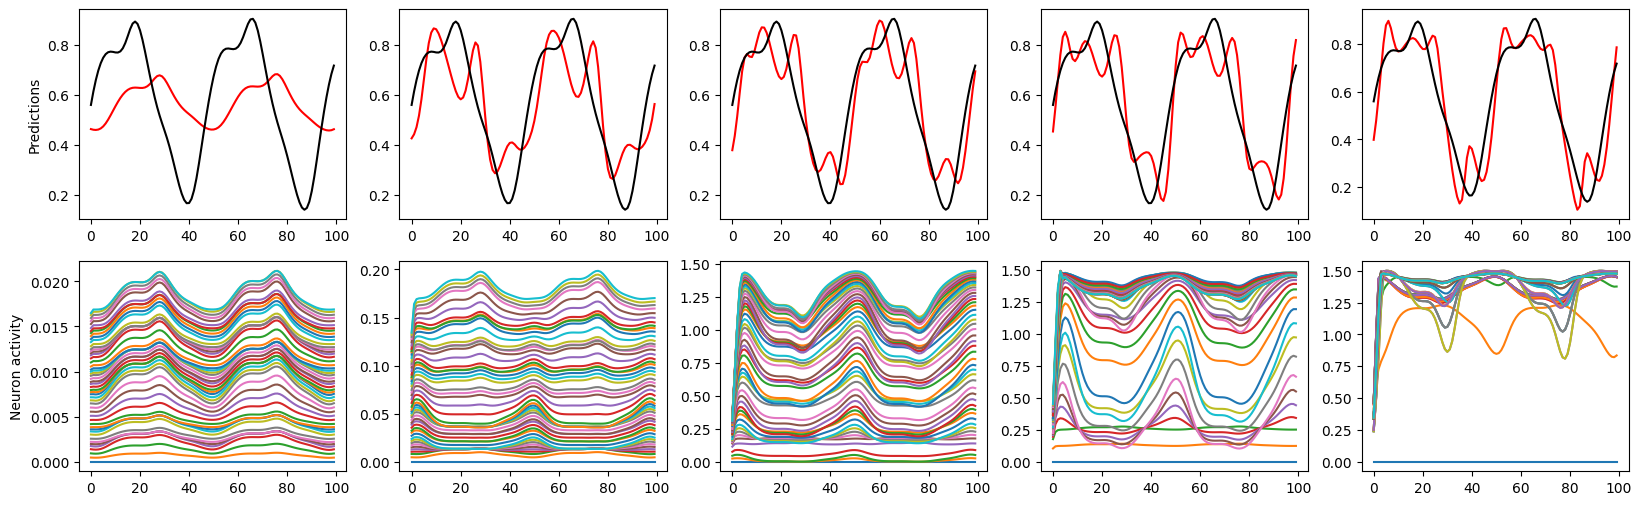

In [14]:
alphas = np.array([0.001, 0.01, 0.1, 0.3, 0.9])
epsilons = tau / (alphas * n_neurones)

fig, ax = plt.subplots(nrows=2, ncols=len(epsilons), figsize=(20, 6))

for i, epsilon in enumerate(epsilons):
    y_pred = run_on_params(n_neurones, tau, epsilon, beta, phi, rho, kappa, ridge)
    activity = Larger(N=n_neurones, tau=tau, kappa=kappa, rho=rho, phi=phi, beta=beta, epsilon=epsilon).run(x_test)
    
    ax[0, i].plot(y_pred, color="red")
    ax[0, i].plot(y_test, color="black")
    print(f"NRMSE({epsilon}) = {nrmse(y_pred, y_test):.4}")
    
    #ax[1, i].plot(activity[-1, :], '-', color="black")
    ax[1, i].plot(activity)

ax[0, 0].set_ylabel("Predictions")
#ax[1, 0].set_ylabel("Neurons state")
ax[1, 0].set_ylabel("Neuron activity")

plt.show()

epsilon = tau / (0.2 * n_neurones)  # Reset de la variable epsilon

#### Paramètre beta $\beta$

Reprenons l'équation obtenue précédemment:
$$x(t+\delta t) = (1 - \alpha) x(t) + \alpha \beta sin^2(\kappa u_{in}(t) + \rho x(t - \tau) + \phi_0)$$

Pour peu que la condition initiale $x(0)$ soit comprise dans l'intervalle $[0, \beta]$ (`x[0] == 0.0` dans notre implémentation), on peut démontrer par récurrence que pour tout $k$, $x(t+k\delta t)$ est dans $[0, \beta]$ (en supposant que $\alpha \in [0, 1]$).

Ainsi, de la même manière que l'activité d'un réservoir comme réseau de neurone récurrent (ESN) avec une fonction d'activation en tangente hyperbolique est confiné entre -1.0 et 1.0, l'activité de ce réservoir optique est borné entre 0.0 et $\beta$.

#### Paramètres kappa $\kappa$, rho $\rho$ et phi $\phi_0$

Supposons que la série temporelle d'entrée $u_{in}$ soit bornée dans $[0, 1]$ (on peut s'y ramener par pré-traitement de l'entrée, ou adapter l'analyse ci-dessous avec les bornes effectives de $u_{in}$). Nous venons également de voir que $x$ est borné dans $[0, \beta]$.

On peut alors établir l'inégalité suivante:

$$\phi_0 < \kappa u_{in}(t) + \rho x(t - \tau) + \phi_0 < \kappa + \rho \beta + \phi_0$$

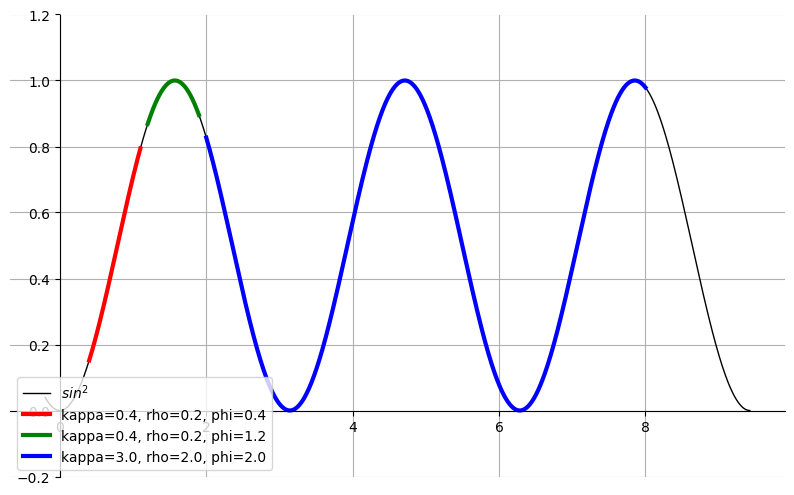

In [15]:
xs = np.linspace(-0.2, 3*np.pi, 1_000)
sin2 = np.square(np.sin(xs))

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.set_ylim(-0.2, 1.2)
ax.plot(xs, sin2, color="black", linewidth=1.0, label="$sin^2$")

beta = 1.5
# kappa=0.4, rho=0.2, phi=0.4
kappa, rho, phi = 0.4, 0.2, 0.4
xa = np.linspace(phi, kappa+rho*beta+phi, 1000)
sin2a = np.square(np.sin(xa))
plt.plot(xa, sin2a, color="red", linewidth=3.0, label=f"{kappa=}, {rho=}, {phi=}")

# kappa=0.4, rho=0.2, phi=1.2
kappa, rho, phi = 0.4, 0.2, 1.2
xa = np.linspace(phi, kappa+rho*beta+phi, 1000)
sin2a = np.square(np.sin(xa))
plt.plot(xa, sin2a, color="green", linewidth=3.0, label=f"{kappa=}, {rho=}, {phi=}")

# kappa=0.4, rho=0.2, phi=2.0
kappa, rho, phi = 3.0, 2.0, 2.0
xa = np.linspace(phi, kappa+rho*beta+phi, 1000)
sin2a = np.square(np.sin(xa))
plt.plot(xa, sin2a, color="blue", linewidth=3.0, label=f"{kappa=}, {rho=}, {phi=}")

plt.grid()
plt.legend()
plt.show()

Sur le graphique ci-dessus, on peut visualiser trois situations en fonction des trois paramètres:

**🔴 En rouge:** Les valeurs prises par le $sin^2$ sont telles que le $sin^2$ est approximable par une fonction affine. On ne profite alors pas du caractère non-linéaire du $sin^2$.

**🟢 En vert:** Les valeurs prises par le $sin^2$ sont telles que le $sin^2$ est approximable par une fonction quadratique. On profite alors du caractère non-linéaire du $sin^2$, et on peut s'attendre à obtenir une dynamique riche du système.

**🔵 En bleu:** La fonction $sin^2$ est hautement non linéaire. On peut alors s'attendre à ce que notre réservoir soit dans un régime chaotique (voir ci-dessous la section *Modélisation du comportement chaotique*).

Pour s'assurer de bénéficier de la non-linéarité du sinus carré tout en évitant de tomber dans un régime chaotique, les paramètres $\kappa, \beta, \rho$ et $\phi_0$ sont à choisir en prenant en compte leur interdépendance.

## Modélisation du comportement chaotique

Pour illustrer le caractère chaotique du système dans certaines conditions, on évalue l'évolution d'une suite définie par récurrence qui est une simplification de notre modèle:

$u_0 = 0$

$u_{n+1} = sin^2(\rho u_n + \phi)$

Cette suite est obtenue pour:
- $\kappa = 0$ ou pas de série temporelle d'entrée
- $\epsilon = 0$ (pas d'interdépendance entre les neurones)
- $\beta = 1$ (pas de gain)

On peut alors évaluer le caractère chaotique de ce système simplifié en fonction des deux hyper-paramètres restants: $\rho$ et $\phi_0$.

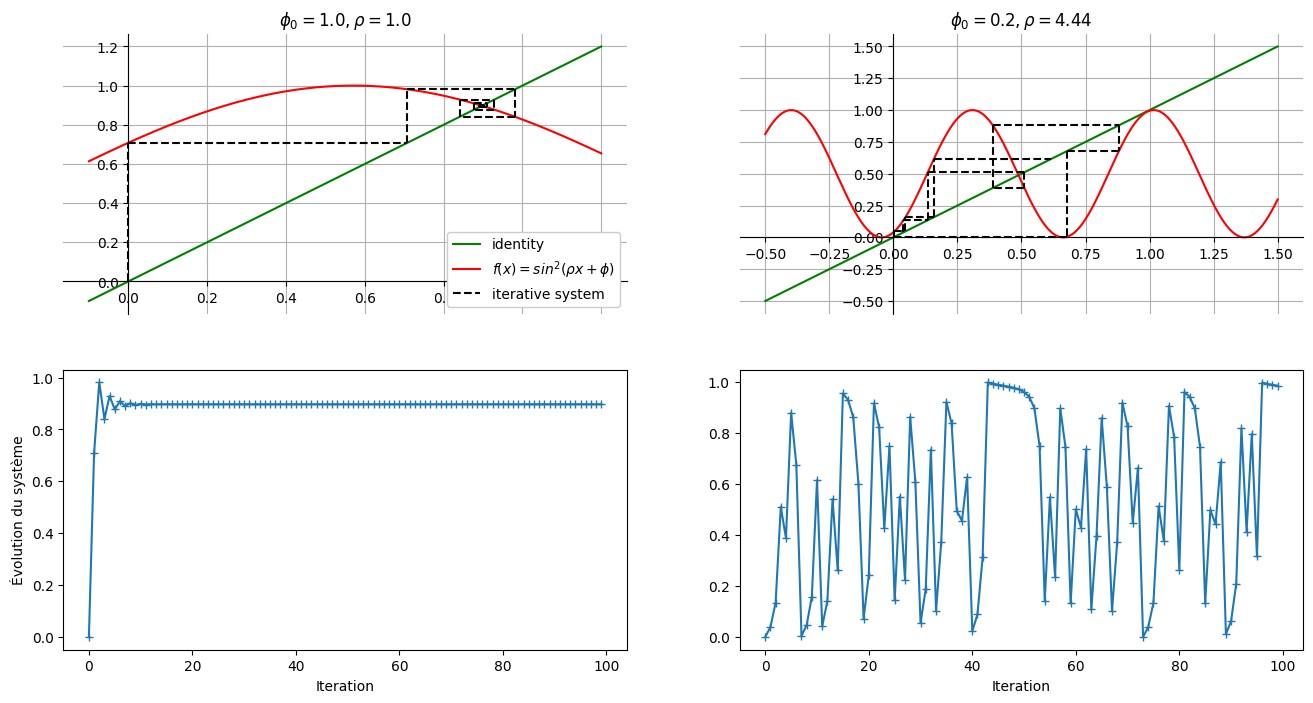

In [16]:
n_iter = 100
plt.figure(figsize=(16, 8))

# Pour phi=1.0, rho=1
phi, rho = 1.0, 1.0
x1 = np.empty(n_iter)
for i in range(1, n_iter):
    x1[i] = np.square(np.sin(rho*x1[i-1]+phi))

plt.subplot(2, 2, 3)
plt.plot(x1, '-+')
plt.xlabel("Iteration")
plt.ylabel("Évolution du système")


plt.subplot(2, 2, 1)

x_vals = np.linspace(-0.1, 1.2, 1000)
system1 = np.square(np.sin(rho*x_vals+phi))

ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')

plt.plot(x_vals, x_vals, color="green", label="identity")
plt.plot(x_vals, system1, color="red", label=r"$f(x) = sin^2(\rho x + \phi)$")
plt.grid()

plotted_iters = 10
assert plotted_iters <= n_iter
for i in range(plotted_iters-1):
    plt.plot([x1[i], x1[i]], [x1[i], x1[i+1]], '--', color="black")  # vertical
    plt.plot([x1[i], x1[i+1]], [x1[i+1], x1[i+1]], '--', color="black")  # horizontal

ax.plot([0], [0], '--', color="black", label="iterative system")  # légende

plt.legend(framealpha=1)
plt.title(f"$\\phi_0 = {phi}, \\rho = {rho}$")

# Pour phi=0.2, rho=4.44
phi, rho = 0.2, 4.44
x2 = np.empty(n_iter)
for i in range(1, n_iter):
    x2[i] = np.square(np.sin(rho*x2[i-1]+phi))

plt.subplot(2, 2, 4)
plt.plot(x2, '-+')
plt.xlabel("Iteration")

plt.subplot(2, 2, 2)

x_vals = np.linspace(-0.5, 1.5, 1000)
system2 = np.square(np.sin(rho*x_vals + phi))

ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')

plt.plot(x_vals, x_vals, color="green", label="identity")
plt.plot(x_vals, system2, color="red", label=r"$f(x) = sin^2(\rho x + \phi)$")
plt.grid()

plotted_iters = 10
assert plotted_iters <= n_iter
for i in range(1, plotted_iters):
    plt.plot([x2[i], x2[i]], [x2[i], x2[i+1]], '--', color="black")  # vertical
    plt.plot([x2[i], x2[i+1]], [x2[i+1], x2[i+1]], '--', color="black")  # horizontal

ax.plot([0], [0], '--', color="black", label="iterative system")  # légende
plt.title(f"$\\phi_0 = {phi}, \\rho = {rho}$")

plt.show()

On constate deux comportements différents pour deux valeurs du couple $(\rho, \phi_0)$ différentes. Dans le premier cas, le système itéré converge sur un point fixe et est stable. Dans le second cas, le système ne semble pas converger.

Pour quelles valeurs de $(\rho, \phi_0)$ a-t-on un système chaotique ?

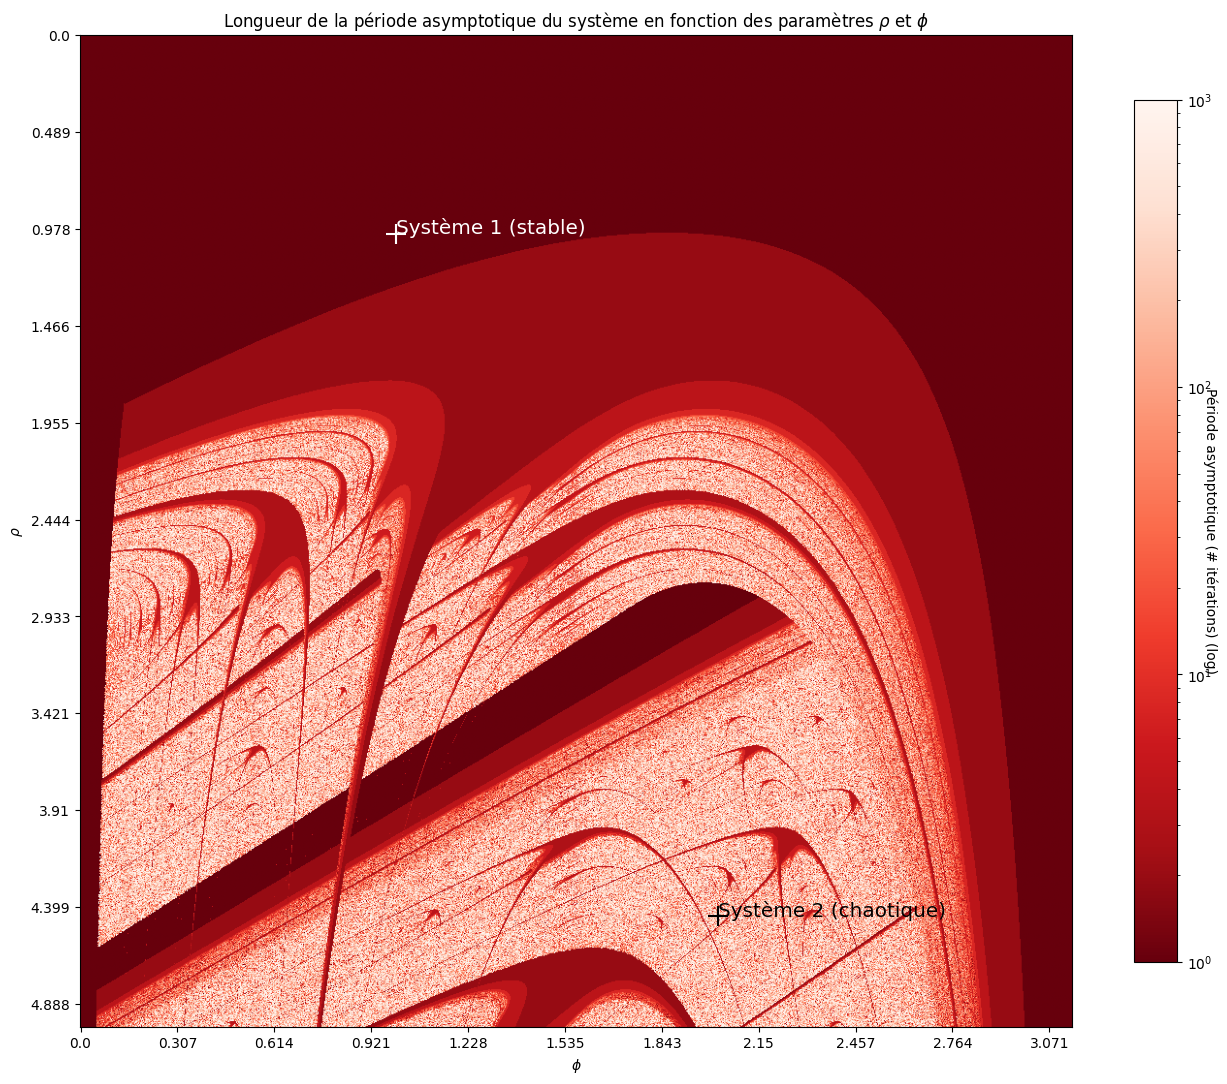

In [17]:
def converges(phi, rho, n_iter=1000, history=1000):
    f = lambda x: np.square(np.sin(rho*x+phi))
    vals = np.zeros(n_iter)
    # Iterate on the system
    for i in range(1, n_iter):
        vals[i] = f(vals[i-1])
    # Find period
    val = f(vals[-1])
    for i in range(n_iter-1, n_iter - history, -1):
        if np.abs(val - vals[i]) < 1/(n_iter):
            return n_iter - i  # Period
    return history


resolution = 1024
enumeration = np.arange(resolution)
phis = np.linspace(0, np.pi, resolution)
rhos = np.linspace(0, 5, resolution)

result = joblib.Parallel(n_jobs=16)(joblib.delayed(converges)(phi, rho) for rho in rhos for phi in phis)
result = np.array(result).reshape(resolution, resolution)

plt.figure(figsize=(16, 16), frameon=False)
plt.scatter([resolution*1/np.pi], [resolution*1/5], s=200, color="white", marker="+")
plt.annotate("Système 1 (stable)", (resolution*1/np.pi, resolution*1/5), color="white", size="x-large")
plt.scatter([resolution*2.02/np.pi], [resolution*4.44/5], s=200, color="black", marker="+")
plt.annotate("Système 2 (chaotique)", (resolution*2.02/np.pi, resolution*4.44/5), color="black", size="x-large")
plt.imshow(result, cmap=plt.get_cmap("Reds").reversed(), norm=colors.LogNorm())
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\rho$")
plt.xticks(enumeration[::100], np.round(phis[::100], 3))
plt.yticks(enumeration[::100], np.round(rhos[::100], 3))
cb = plt.colorbar(shrink=0.7)
cb.ax.set_ylabel("Période asymptotique (# itérations) (log)", rotation=270)
plt.title("Longueur de la période asymptotique du système en fonction des paramètres $\\rho$ et $\\phi$")
plt.show()

Interprétation: le graphique représente pour chaque couple (rho, phi) la période asymptotique dy système:

Dans les zones rouges, le système converge sur un point fixe, comme dans le premier cas de la figure précédente ($\phi=1, \rho=1$). Sa période est donc de 1 puisque $u_{n+1} \approx u_n$.

Dans les zones claires, le système a un comportement chaotique, comme dans le second cas de la figure précédente.